# Week 4 - Exploring Semantic Spaces (Word Embeddings)
This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them.

This is our third document representation we have learned: First, we used word counts. Second, we used LDA topic models built around term coocurrence in the same document (i.e., a "bag of words"). Third, documents here are represented as densely indexed locations in dimensions, so that distances between those documents (and words) contain more information, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

Note that most modern natural language processing (NLP) research, at least in computer science, uses word embeddings. This is the foundation of most state-of-the-art models.

In [17]:
pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-zusvt3ox
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-zusvt3ox


In [19]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec` and/or `fasttext`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<font color="red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

In [6]:
import pandas as pd

In [7]:
mbti = pd.read_csv("/content/drive/MyDrive/MBTI 500.csv") 

In [13]:
mbti.head(5) #the dataset contains posts made by users who
            #identified themselves as one of the MBTI types ("INTJ", "ENFP", etc.)

,posts,type
0,know intj tool use interaction people excuse a...,INTJ
1,rap music ehh opp yeah know valid well know fa...,INTJ
2,preferably p hd low except wew lad video p min...,INTJ
3,drink like wish could drink red wine give head...,INTJ
4,space program ah bad deal meing freelance max ...,INTJ


In [44]:
df = (mbti.loc[mbti['type'] == 'INTJ'])[:500] #only posts made by "INTJs" are included in the small sample

In [45]:
len(df)

500

In [46]:
df['tokenized_sents'] = df['posts'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
df['normalized_sents'] = df['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

In [47]:
dfW2V = gensim.models.word2vec.Word2Vec(df['normalized_sents'].sum(), sg=0)

In [281]:
dfW2V.most_similar('love')

[('great', 0.9993513226509094),
 ('enjoy', 0.9993342161178589),
 ('win', 0.9993133544921875),
 ('nice', 0.9992208480834961),
 ('girl', 0.9992009401321411),
 ('happy', 0.9991782307624817),
 ('guy', 0.9991720914840698),
 ('luck', 0.999172031879425),
 ('fun', 0.9991632699966431),
 ('stuff', 0.9991630911827087)]

In [283]:
dfW2V.most_similar('relationship')

[('find', 0.9993046522140503),
 ('try', 0.9992921948432922),
 ('win', 0.9992572069168091),
 ('advice', 0.9991918206214905),
 ('maybe', 0.999175488948822),
 ('great', 0.9991642236709595),
 ('date', 0.9991617798805237),
 ('meet', 0.9991480708122253),
 ('love', 0.9991269707679749),
 ('luck', 0.999119758605957)]

In [284]:
dfW2V.doesnt_match(['love', 'family', 'relationship'])

'family'

In [286]:
dfW2V.most_similar(positive=['love', 'family'], negative = ['relationship'])

[('music', 0.9992460608482361),
 ('movie', 0.9991723895072937),
 ('card', 0.9991663694381714),
 ('headphone', 0.9991554021835327),
 ('tv', 0.9991426467895508),
 ('house', 0.999139666557312),
 ('etc', 0.9991240501403809),
 ('board', 0.9991210699081421),
 ('company', 0.9991116523742676),
 ('prone', 0.9991104006767273)]

In [ ]:
numWords = 100
targetWords = dfW2V.wv.index2word[:numWords]

wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(dfW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

In [92]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

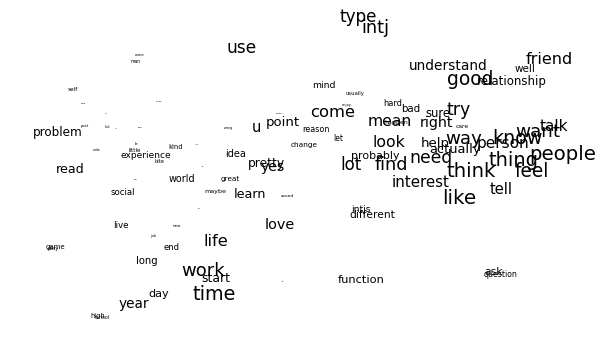

In [93]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

In [279]:
word = u'love'  
ss = dfW2V.wv.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to love is: 
great
enjoy
win
nice
girl
happy
guy
luck
fun
stuff



In [280]:
word = u'relationship'  
ss = dfW2V.wv.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

the most similar words to relationship is: 
find
try
win
advice
maybe
great
date
meet
love
luck



For some key terms that I am interested in such as "love" and "relationship", the patterns reveal that the sentiments in the posts regarding "love" is pretty postive. As a result, some active verbs (e.g. find, try, win, etc.) are found to be most similar to the word "relationship". One odd result obtained is that I have no idea how "love-relationship" is analogous to "family-music" and "family-headphone".    

In [82]:
#fast-text
model = fasttext.train_unsupervised("/content/df.txt", model='cbow')

In [287]:
model.words[:10]

['like',
 'people',
 'get',
 'think',
 'make',
 'thing',
 'go',
 'time',
 'know',
 'one']

In [292]:
[model.get_word_vector(x) for x in ["love", "family", "relationship"]]

[array([ 0.32410797,  0.01970364,  0.08881207,  0.25040418,  0.00640054,
         0.4821655 ,  0.27869207, -0.04918137,  0.34630236, -0.0160548 ,
        -0.04308524, -0.05771228, -0.08484132,  0.22864355, -0.22014663,
        -0.00869861, -0.12477255,  0.05119818, -0.00405022, -0.01247187,
         0.10889203,  0.23428415, -0.27709413,  0.3786932 , -0.10242614,
         0.13360646,  0.2284725 ,  0.11949021, -0.3915986 ,  0.2312994 ,
        -0.2548231 , -0.24827334,  0.0964344 , -0.16920117, -0.01759475,
        -0.09540834, -0.08261921,  0.19672126,  0.28214392, -0.2529496 ,
        -0.13204566, -0.10782336,  0.08341409, -0.09438344,  0.3185502 ,
        -0.08569606, -0.19603452,  0.19769733, -0.14344005,  0.31939936,
        -0.4125789 , -0.46501985, -0.14229459,  0.12725127, -0.12206879,
        -0.05957346, -0.4697108 ,  0.22507493, -0.21281065,  0.41469142,
         0.1887894 , -0.07697912,  0.1958402 , -0.24298045,  0.18806098,
         0.12742496, -0.2684915 , -0.05246006, -0.0

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

In [135]:
df = (mbti.loc[mbti['type'] == 'INTJ'])[:500]

In [136]:
df = df.reset_index()
df.head(5)

,index,posts,type
0,0,know intj tool use interaction people excuse a...,INTJ
1,1,rap music ehh opp yeah know valid well know fa...,INTJ
2,2,preferably p hd low except wew lad video p min...,INTJ
3,3,drink like wish could drink red wine give head...,INTJ
4,4,space program ah bad deal meing freelance max ...,INTJ


In [137]:
df['tokenized_words'] = df['posts'].apply(lambda x: lucem_illud.word_tokenize(x))
df['normalized_words'] = df['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, lemma=False))

In [180]:
keywords = ['love', 'family', 'relationship', 'emotion', 'work', 'logic', 
            'introversion', 'intuition', 'study', 'passion','insight',
            'care','partner', 'antisocial']

In [181]:
taggedDocs = []
for index, row in df.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['index'])
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
df['TaggedPosts'] = taggedDocs

In [182]:
dfD2V = gensim.models.doc2vec.Doc2Vec(df['TaggedPosts'], size = 100)

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [183]:
dfD2V.most_similar(positive = ['love','relationship'], negative = ['family'], topn = 1)

[('romantic', 0.9973980188369751)]

In [184]:
dfD2V.most_similar(positive = ['love','relationship'], negative = ['family'], topn = 3) #topn indicates the # of words shown

[('romantic', 0.9973980188369751),
 ('friend', 0.9965231418609619),
 ('feel', 0.9956435561180115)]

In [185]:
dfD2V.docvecs.most_similar([ dfD2V['love'] ])

[(130, 0.9983829855918884),
 (304, 0.9982265830039978),
 ('passion', 0.998146653175354),
 (70, 0.998132586479187),
 (186, 0.9981314539909363),
 (181, 0.9981149435043335),
 ('antisocial', 0.9980394244194031),
 (433, 0.9980173110961914),
 (89, 0.9979085922241211),
 (56, 0.9979033470153809)]

In [186]:
#Now let's go the other way around and find words most similar to this document:
dfD2V.most_similar( [ dfD2V.docvecs[5] ], topn=5) 

[('internet', 0.9991391897201538),
 ('age', 0.9991341233253479),
 ('thank', 0.999121367931366),
 ('second', 0.9991178512573242),
 ('entire', 0.99910569190979)]

In [187]:
dfD2V.docvecs.most_similar([ dfD2V['love']+dfD2V['family']], topn=5 ) #matches the documents appear in the cell above

[(130, 0.9993596076965332),
 (304, 0.9992493987083435),
 (186, 0.9992043972015381),
 (181, 0.9991783499717712),
 ('antisocial', 0.9991679191589355)]

In [192]:
targetDocs = df['index'][:20]

In [200]:
docs =  df['index'][[130,304,186, 181]]

In [196]:
heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = dfD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, dfD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

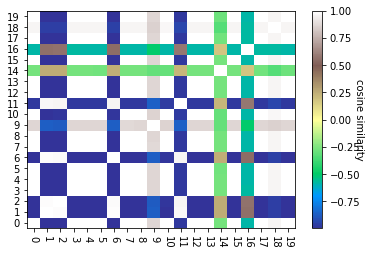

In [197]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

In [205]:
heatmapMatrixD = []

for tagOuter in [130,304,186, 181]:
    column = []
    tagVec = dfD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in [130,304,186, 181]:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, dfD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

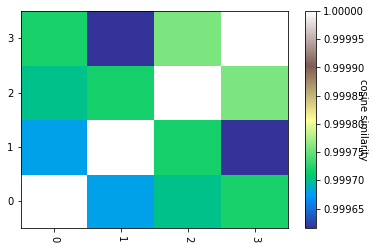

In [206]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

In [193]:
Nkeywords = keywords

In [207]:
heatmapMatrix = []
for tagOuter in Nkeywords:
    column = []
    tagVec = dfD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in Nkeywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, dfD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

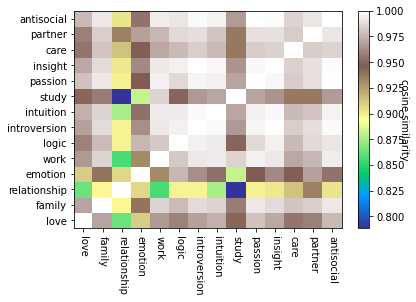

In [208]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(Nkeywords, minor=False, rotation=270)
a = ax.set_yticklabels(Nkeywords, minor=False)

In [194]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = dfD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in Nkeywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, dfD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

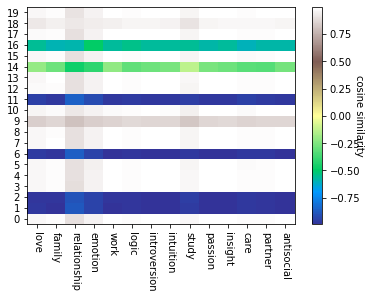

In [195]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(Nkeywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)
#more negative number indicates lower similarities 

From the heatmaps, we can conclude that most of the documents are closely related to each other (many of them have a cosine similarity close to 1). Only Doc 1,2,6, and 11 are clearly different from other documents. As a result, they also failed to associated with the keywords (e.g. love, family, etc.) that related to other documents. We can learn from the heatmaps that the predefined list of keywords are also very similar in distance. Thus, we saw that whenever one word appears in the document, the same document also has close distnace with the other words.       

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<font color="red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

In [216]:
#words to create dimensions
myTargetWords = ['social','hyper','warm','quiet','lonely','distant','cold','smart','intellectual',
                 'dumb','slow','care','distant','emotion','logic', 'artist','lawyer','actor',
                 'doctor','singer','math','detail','criticism','praise','cheer',
                 'lazy','passionate']

wordsSubMatrix = []
for word in myTargetWords:
    wordsSubMatrix.append(dfW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [218]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 10).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

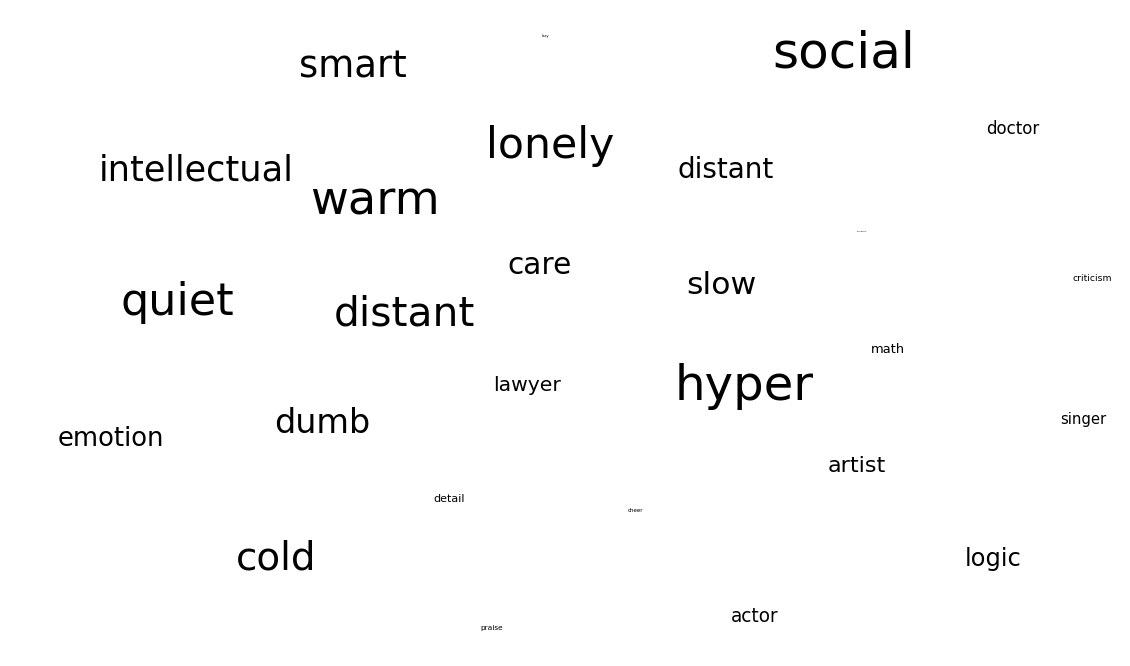

In [220]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(myTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(myTargetWords) - i) / len(myTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

In [293]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [228]:
personality = ['social','hyper','warm', 'quiet','lonely','distant']
thoughts = ['smart','intellectual','logic','dumb','slow','emotion']
career = ['artist', 'actor', 'singer','lawyer', 'doctor', 'math']

In [240]:
person_type = dimension(dfW2V, ['introversion'], ['extroversion'])
gender_type = dimension(dfW2V, ['male'], ['female'])

In [243]:
def makeDF(model, word_list):
    g = []
    r = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(dfW2V[word].reshape(1,-1), person_type.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(dfW2V[word].reshape(1,-1), gender_type.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'personality': g, 'gender': r}, index = word_list)
    return df

In [244]:
perdf = makeDF(dfW2V, personality) 
thoudf = makeDF(dfW2V, thoughts)
careerdf = makeDF(dfW2V, career)

Define some useful functions for plotting.

In [237]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

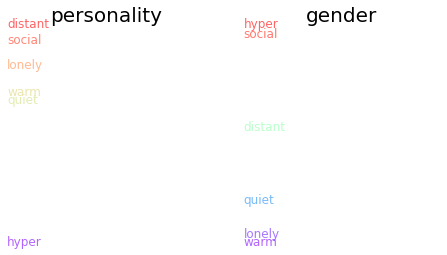

In [246]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, perdf, 'personality')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, perdf, 'gender')
plt.show()

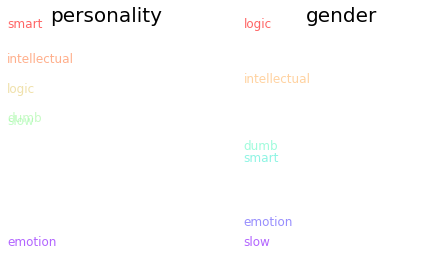

In [247]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, thoudf, 'personality')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, thoudf, 'gender')
plt.show()

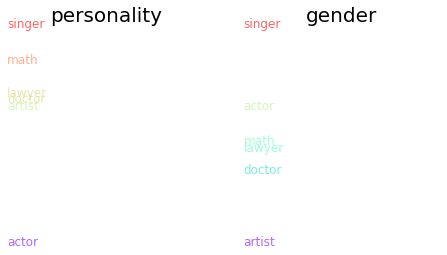

In [248]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, careerdf, 'personality')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, careerdf, 'gender')
plt.show()

I defined two dimensions for the dataset: personality type (i.e. introversion vs. extroversion) and gender (i.e. male vs. female). According to the projections, we learn that introversion is closer to traits like "distant" and (surprisingly) "social" but is away from "hyper". They tend to be smart and logic, and have a career as singers or math-related. The male category is closer to terms like "hyper","social", "logic", and "singer". I think the personality dimension explain more of the variations since the terms are more polarized.      